# Intro to Argovis' Drifter API

Argovis indexes a subset of the hourly dataset from the [NOAA Global Drifter Program](https://www.aoml.noaa.gov/phod/gdp/index.php), version 2.00 (beta pre-release) ([Elipot et al. 2016](http://dx.doi.org/10.1002/2016JC011716), [Elipot et al. 2022 arXiv preprint](https://arxiv.org/abs/2201.08289v1)). In this notebook, we tour basic search and colocation options for this dataset.

> **This is a beta product!**
> Argovis' new API is currently undergoing heavy development. Therefore, everything in these notebooks should be understood as a technical preview only; implementation details may change before a 
stable release is made. Please send feedback and ideas to argovis@colorado.edu, and see the API docs as they evolve at https://argovis-api.colorado.edu/docs/.

## Setup

In addition to importing a few python packages and declaring a couple of helper functions, make sure to plug in your Argovis API key for `API_KEY` at the bottom of the next cell. If you don't have a free Argovis API key yet, get one at https://argovis-keygen.colorado.edu/.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import datetime, time, json, requests, pprint, copy
from argovisHelpers import helpers as avh

def polygon_lon_lat(polygon_str):
    # polygon_str: string value of polygon search parameter, ie "[[lon0,lat0],[lon1,lat1],...,[lon0,lat0]]"
    # convert the polygon shape to lon and lat and save in a dictionary
    polygon_lon_lat_dict = {'lon': [float(i) for i in ((polygon_str.replace('[','')).replace(']','')).split(',')[0::2]], \
                    'lat': [float(i) for i in ((polygon_str.replace('[','')).replace(']','')).split(',')[1::2]]
                   }
    return polygon_lon_lat_dict

def simple_map(longitudes, latitudes, z=None, polygon=None, title='', fig=None, figIndex=None, marker=None):
    if fig:
        ax = fig.add_subplot(figIndex[0], figIndex[1], figIndex[2], projection=ccrs.LambertConformal())
    else:
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())
    gl = ax.gridlines(draw_labels=True,color='black')
    if z:
        s = ax.scatter(longitudes, latitudes, c=z, transform=ccrs.PlateCarree())
        plt.colorbar(s, pad=0.1)
    else:
        s = ax.scatter(longitudes, latitudes,transform=ccrs.PlateCarree())
    if polygon:
        plt.plot(polygon_lon_lat(str(polygon))['lon'],polygon_lon_lat(str(polygon))['lat'],'-k',transform=ccrs.PlateCarree()) 
    if marker:
        plt.plot(marker[0],marker[1],'Xr', transform=ccrs.PlateCarree(), markersize=20)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND)
    plt.title(title, fontdict={'fontsize':20})

API_KEY=''
API_PREFIX='https://argovis-drifters.colorado.edu/'

## Downloading & Colocating Drifter Data

Drifter data is searchable in Argovis with the following query parameters:

 - `startDate` (geo-constrained, see below, format YYYY-MM-DDTHH:MM:SSZ at GMT0): beginning of time window to query.
 - `endDate` (geo-constrained, see below, format YYYY-MM-DDTHH:MM:SSZ at GMT0): end of time window to query.
 - `polygon` (geo-constrained, see below, format [[lon0,lat0],[lon1,lat1],...,[lonN,latN],[lon0,lat0]]): geographical region to query.
 - `center` + `radius` (geo-constrained, see below, center format lon,lat ; raidus format distance in km): geographical region to query, defined as maximum distance (radius) from a point (center).
 - `platform` (optional): query estimates from the unique piece of hardware with this ID number.
 - `wmo` (optional): query all estimates from all platforms corresponding to this World Metrological Organization ID.
 - `id` (optional): query a specific drifter measurement, encoded as `<platform>_<measurement number>`, where measurement number starts from 0.
 
**Items marked 'geo-constrained'** are individually optional, but have soft limits based on estimates of how much data they will return. If you need to query a large area, consider making requests over a short timespan; or vice versa. These limits are waived when asking for a specific `platform` or `wmo`.

Users of Argovis will notice that many of these parameters appear in the Profiles API, which serves profile data from devices like Argo and GO-SHIP floats. Where Argovis APIs share query parameter names, they can be interpreted identically, per the following. Notice also that drifters are served from a different API root than other Argo products, so we pass in the correct URL root to each request:

In [2]:
common_params = {
  "startDate": '2013-01-01T00:00:00Z',
  "endDate": '2013-01-10T00:00:00Z',
  "polygon": [[-75,42],[-75,38],[-62,38],[-62,42],[-75,42]]
}

drifter_params = copy.deepcopy(common_params)
drifter_params['data'] = 'sst'
    
drifters = avh.query('drifters', options=drifter_params, apikey=API_KEY, apiroot=API_PREFIX)
floats = avh.query('argo', options=common_params, apikey=API_KEY, apiroot='https://argovis-api.colorado.edu/')

`drifters` and `floats` now contain the drifter and float measurements, respectively, found in the space/time region queried - 52 square degrees of the North Atlantic Ocean for the first 10 days of 2013. We can extract some data and plot the drifter and float locations as per:

/usr/local/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


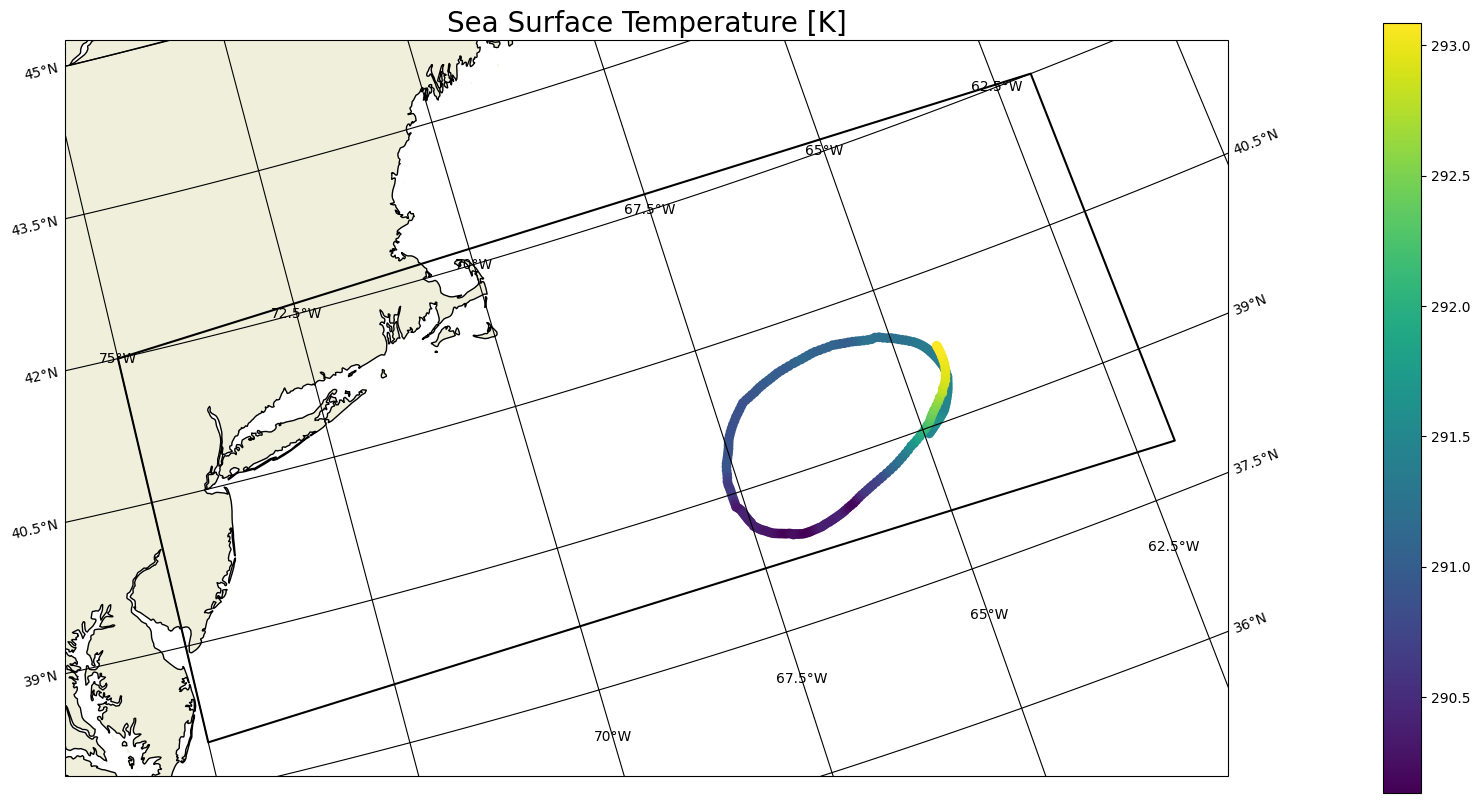

In [3]:
drifter_longitudes = [x['geolocation']['coordinates'][0] for x in drifters]
drifter_latitudes  = [x['geolocation']['coordinates'][1] for x in drifters]
drifter_sst = [x['data'][x['data_info'][0].index('sst')][0] for x in drifters]
drifter_dates = [ avh.parsetime(x['timestamp']).timestamp() for x in drifters]

simple_map(drifter_longitudes,drifter_latitudes,drifter_sst,common_params['polygon'], 'Sea Surface Temperature [K]')

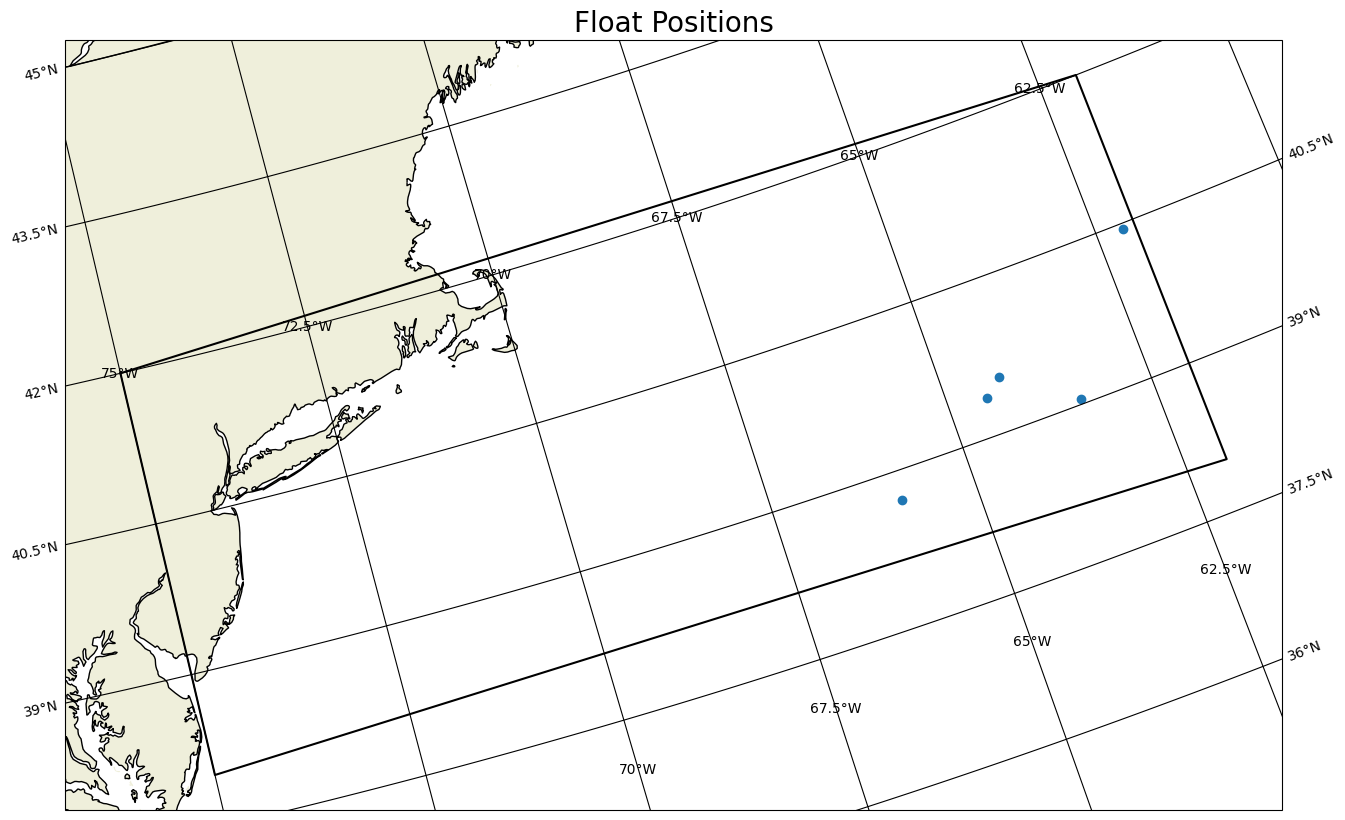

In [4]:
float_longitudes = [x['geolocation']['coordinates'][0] for x in floats]
float_latitudes  = [x['geolocation']['coordinates'][1] for x in floats]

simple_map(float_longitudes,float_latitudes,polygon=common_params['polygon'], title='Float Positions')

In the above, we asked for profiling floats in the same geographic box as our drifter search. We can make this colocation more exact by asking for drifter measurements within a certain distance of our profiling floats, in a tighter time window as well. Let's also re-fetch the profiling float data, this time with temperature and pressure measurements we'd like to plot later:

In [5]:
# redo the float search, with pressure and temperature data included this time
float_params = copy.deepcopy(common_params)
float_params['data'] = 'pressure,temperature'
floats_with_data = avh.query('argo', options=float_params, apikey=API_KEY, apiroot='https://argovis-api.colorado.edu/')

# search for drifters near these floats
buddies = {}

for f in floats_with_data:

    colo_params = {
        'startDate': avh.parsetime((avh.parsetime(common_params['startDate']) + datetime.timedelta(minutes=-90))),
        'endDate': avh.parsetime((avh.parsetime(common_params['startDate']) + datetime.timedelta(minutes=90))),
        'radius': 50,
        'center': str(f['geolocation']['coordinates'][0]) + ',' + str(f['geolocation']['coordinates'][1]),
        'data': 'sst'
    }
    buddies[f['_id']] = avh.query('drifters', options=colo_params, apikey=API_KEY, apiroot=API_PREFIX)

It's then a simple matter to plot the adjacent drifters to a given float. In the plot on the left, we have the sea surface temperature from the drifter measurements within 50 km of the float, marked by the red X. On the right, we have temperatures as a function of depth, with the drifter surface measurements marked in blue, and the float profile in red.

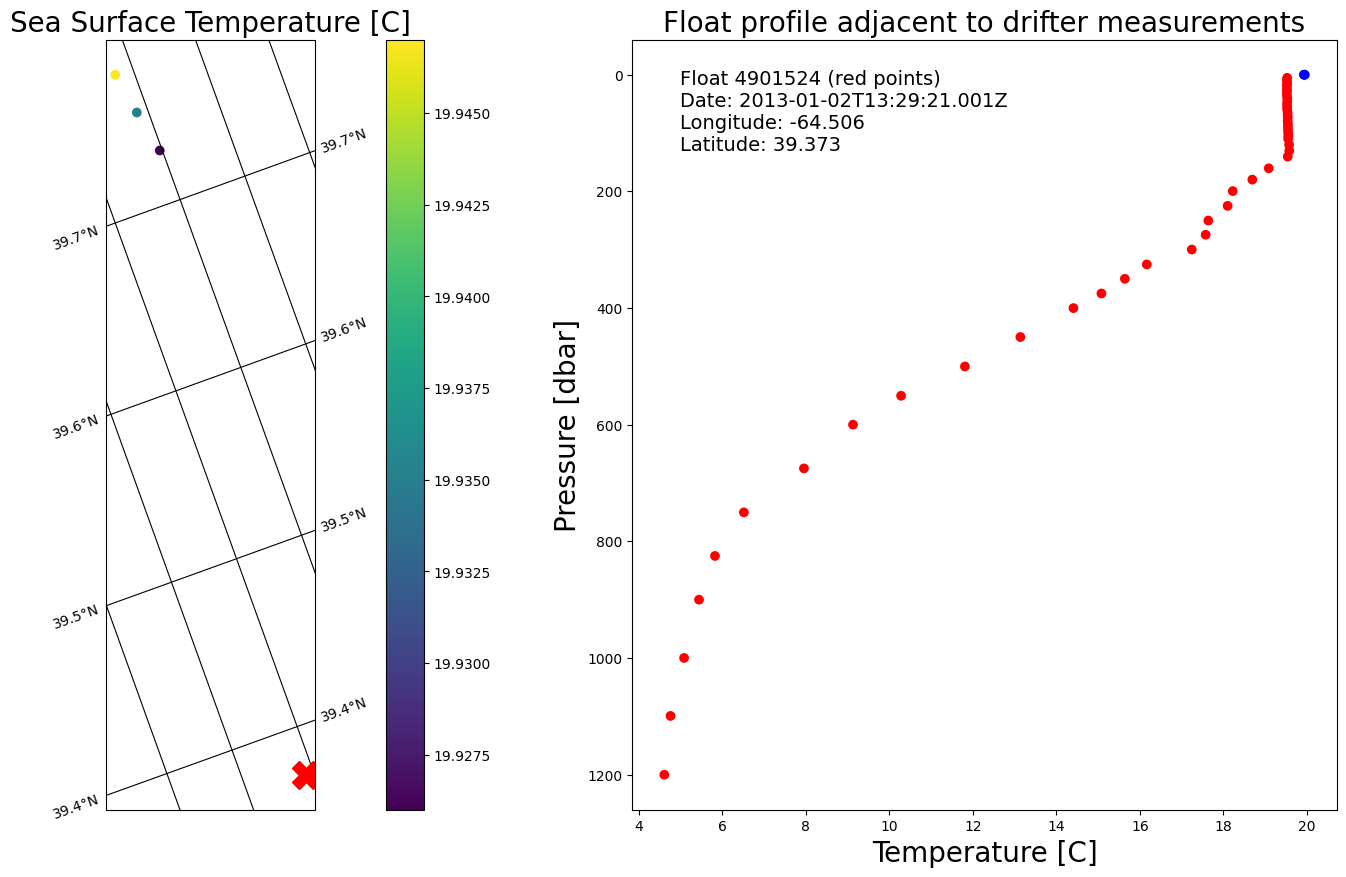

In [6]:
float_ids = list(buddies)
ifloat = 4

if len(buddies[float_ids[ifloat]]) == 0:
    print('No drifters found proximate to this float. Try a different float!')
else:
    buddy_sst = [x['data'][x['data_info'][0].index('sst')][0]-273.15 for x in buddies[float_ids[ifloat]]]
    buddy_lon = [x['geolocation']['coordinates'][0] for x in buddies[float_ids[ifloat]]]
    buddy_lat = [x['geolocation']['coordinates'][1] for x in buddies[float_ids[ifloat]]]
    float_record = [x for x in floats_with_data if x['_id'] == float_ids[ifloat]][0]
    float_lon = float_record['geolocation']['coordinates'][0]
    float_lat = float_record['geolocation']['coordinates'][1]

    f = plt.figure(figsize=(20,10))
    simple_map(buddy_lon, buddy_lat, z=buddy_sst, title='Sea Surface Temperature [C]', fig=f, figIndex=[1,2,1], marker=[float_lon,float_lat])

    tempindex = float_record['data_info'][0].index('temperature')
    presindex = float_record['data_info'][0].index('pressure')
    combined_temps = float_record['data'][tempindex] + buddy_sst
    combined_pres  = float_record['data'][presindex] + [0]*len(buddy_sst)
    colors = [1]*len(float_record['data'][tempindex]) + [0]*len(buddy_sst)
    profile = f.add_subplot(1, 2, 2)
    profile.scatter(combined_temps, combined_pres, c=colors, cmap='bwr')
    plt.gca().invert_yaxis()
    plt.title('Float profile adjacent to drifter measurements',fontdict={'fontsize':20})
    plt.xlabel('Temperature [C]',fontdict={'fontsize':20})
    plt.ylabel('Pressure [dbar]',fontdict={'fontsize':20})
    t = profile.text(5, 130, 'Float ' + float_record['metadata'][0].split('_')[0] + ' (red points)\nDate: ' + float_record['timestamp'] + '\nLongitude: ' + str(float_record['geolocation']['coordinates'][0]) + '\nLatitude: ' + str(float_record['geolocation']['coordinates'][1]),fontdict={'fontsize':14})

## Exploring Drifter Metadata

In addition to drifter estimate data, Argovis also indexes tables of drifter metadata. Similar to the data searched above, drifter metadata can be filtered by `wmo` and `platform` IDs. To see a list of all the possible values of these indexes, try the `/drifters/vocabulary` endpoint:

In [7]:
vocab_params = {
    'parameter': 'platform' # could also be 'wmo'
}
wmos = avh.query('drifters/vocabulary', options=vocab_params, apikey=API_KEY, apiroot=API_PREFIX)
print(wmos[0:10])

['10050130', '10051120', '10051130', '10053160', '10054120', '10054140', '10054160', '10055120', '10055130', '10055160']


Given a platform identifier, we can fetch the corresponding metadata from the `/drifters/meta` endpoint:

In [8]:
meta_params = {
    "platform": '10050130'
}

meta = avh.query('drifters/meta', options=meta_params, apikey=API_KEY, apiroot=API_PREFIX)
pprint.pprint(meta)

[{'_id': '10050130',
  'data_info': [['ve',
                 'vn',
                 'err_lon',
                 'err_lat',
                 'err_ve',
                 'err_vn',
                 'gap',
                 'sst',
                 'sst1',
                 'sst2',
                 'err_sst',
                 'err_sst1',
                 'err_sst2',
                 'flg_sst',
                 'flg_sst1',
                 'flg_sst2'],
                ['units', 'long_name'],
                [['m/s', 'Eastward velocity'],
                 ['m/s', 'Northward velocity'],
                 ['degrees_east', '95% confidence interval in longitude'],
                 ['degrees_north', '95% confidence interval in latitude'],
                 ['m/s', '95% confidence interval in eastward velocity'],
                 ['m/s', '95% confidence interval in northward velocity'],
                 ['seconds',
                  'time interval between previous and next location fix'],
              